# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Read the datasets

In [3]:
# path to the files
attacks_path = '../data/2024-adatelemzo-msc/ddos_data.attacks.anonimized.csv'
vectors_path = '../data/2024-adatelemzo-msc/ddos_data.vectors.anonimized.csv'

In [4]:
attack_df = pd.read_csv(attacks_path)
attack_df.head()

,Attack ID,Card,Victim IP,Port number,Attack code,Detect count,Significant flag,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,End time,Whitelist flag,Type
0,1,sga10gq0,IP_0001,4500,High volume traffic,1,0,55600,73,1383,6,2022-08-08T18:09:36,2022-08-08T18:09:37,0,Normal traffic
1,2,sga10gq0,IP_0002,4500,High volume traffic,1,0,63500,90,1506,1,2022-08-08T18:37:28,2022-08-08T18:37:28,0,Normal traffic
2,3,sga10gq0,IP_0003,1200,High volume traffic,2,0,62700,82,1399,1,2022-08-08T18:41:25,2022-08-08T18:41:26,0,Normal traffic
3,4,sga10gq0,IP_0002,4500,High volume traffic,1,0,59500,85,1486,1,2022-08-08T18:47:49,2022-08-08T18:47:50,0,Normal traffic
4,5,sga10gq0,IP_0004,12347,High volume traffic,2,1,78250,113,1518,1,2022-08-08T18:57:15,2022-08-08T18:58:11,0,Normal traffic


In [5]:
vector_df = pd.read_csv(vectors_path)
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49


# Attacks dataframe

Type
Normal traffic        124137
Suspicious traffic      9707
DDoS attack              926
Name: count, dtype: int64


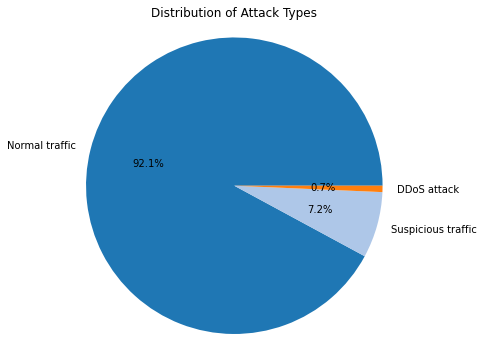

In [6]:
# see how many records are in different classes
value_counts = attack_df['Type'].value_counts()
labels = sorted(value_counts.index)
print(value_counts)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(value_counts.values, labels = value_counts.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors)
plt.axis('equal')
plt.title("Distribution of Attack Types")

plt.savefig('../imgs/attack_df_type_dist.jpg', bbox_inches='tight')
plt.show()

## Attack labels

In [7]:
# see how many records are with different attack codes of not normal traffic
value_counts = attack_df['Attack code'].value_counts()
print(value_counts)

Attack code
High volume traffic                                                             124137
Suspicious traffic                                                                6567
Suspicious traffic, High volume traffic                                           3140
SYN Attack                                                                         246
DNS                                                                                129
Generic UDP                                                                        122
Generic UDP, Suspicious traffic                                                     96
Generic UDP, High volume traffic                                                    75
CLDAP, High volume traffic                                                          49
NTP                                                                                 34
CLDAP                                                                               22
Suspicious traffic, DNS, High v

In [8]:
# there are multiple labels on some attacks
# get all the labels
attack_labels_mixed = list(value_counts.index)
attack_labels = []
for mixed_label in attack_labels_mixed:
  for label in mixed_label.split(','):
    attack_labels.append(label.strip())
# get the distinct labels
attack_labels = list(set(attack_labels))
attack_labels

['High volume traffic',
 'CLDAP',
 'ACK Attack',
 'Generic UDP',
 'RPC',
 'CoAP',
 'SSDP',
 'TCP Anomaly',
 'Sentinel',
 'SNMP',
 'CHARGEN',
 'IPv4 fragmentation',
 'Suspicious traffic',
 'RDP',
 'SYN Attack',
 'DNS',
 'NTP']

These can be one-hot-encoded, however this is not neccessary for the data analysis

In [9]:
# count attacks for each label
label_count = {}
for label in attack_labels:
  count = attack_df['Attack code'].str.contains(label, case=False).sum()
  label_count[label] = count

# add all attack count
label_count['All attacks'] = len(attack_df)

# order the dict by frequency
label_count = dict(sorted(label_count.items(),key=lambda item: item[1], reverse = True))

for l, c in label_count.items():
  print(f"{l} : {c}")

All attacks : 134770
High volume traffic : 127489
Suspicious traffic : 9888
Generic UDP : 312
SYN Attack : 248
DNS : 176
CLDAP : 82
NTP : 71
IPv4 fragmentation : 23
CoAP : 11
TCP Anomaly : 11
SSDP : 9
Sentinel : 5
ACK Attack : 3
CHARGEN : 2
RPC : 1
SNMP : 1
RDP : 1


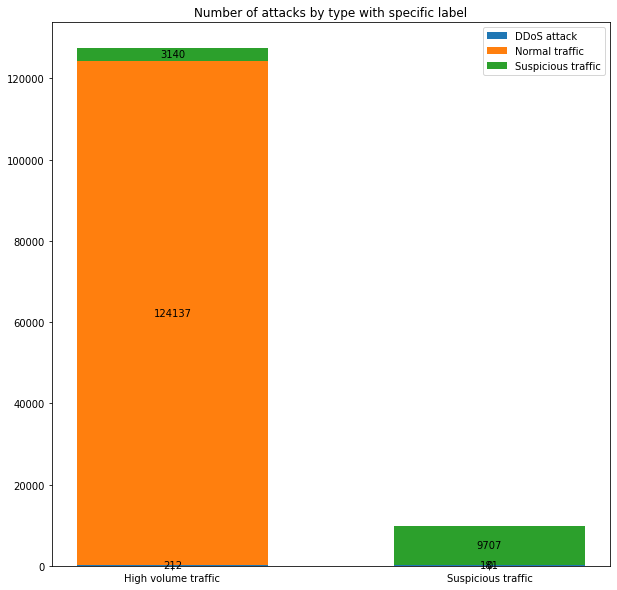

In [10]:
# lets check the class distribution for each label
# high volume and suspicious traffic are the most frequent lets check them seperately

# get the frequency of each class
attack_labels_to_plot = ('High volume traffic', 'Suspicious traffic')
num_attacks_by_type = {label: [] for label in labels}

for attack_label in attack_labels_to_plot:
  for k, _ in num_attacks_by_type.items():
    attack_label_df = attack_df[(attack_df['Attack code'].str.contains(attack_label, case=False))
                                & (attack_df['Type'] == k)]
    num_attacks_by_type[k].append(len(attack_label_df))

num_attacks_by_type

# plot it on a barplot
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
bottom = np.zeros(len(attack_labels_to_plot))

for label, count in num_attacks_by_type.items():
    p = ax.bar(attack_labels_to_plot, count, width, label=label, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of attacks by type with specific label')
ax.legend()

plt.savefig('../imgs/attack_df_attack_label_big.jpg', bbox_inches='tight')
plt.show()

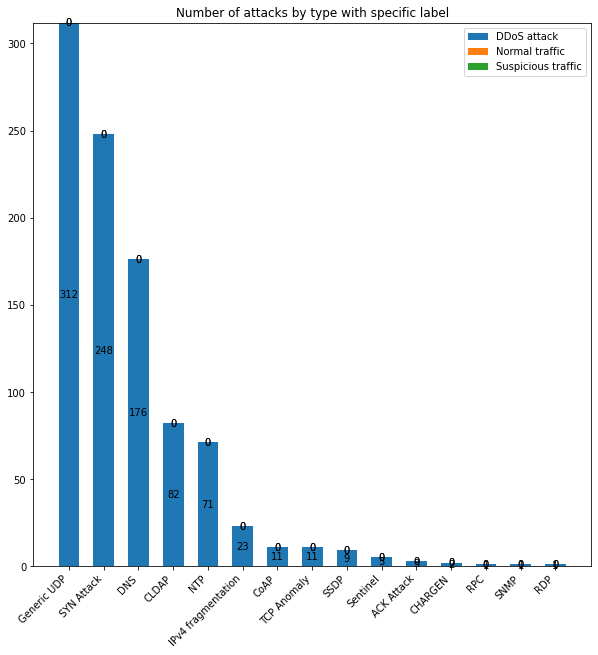

In [11]:
# check for the other labels
# lets check the class distribution for each label
# high volume and suspicious traffic are the most frequent lets check them seperately

# get the frequency of each class
attack_labels_to_plot = list(label_count.keys())[3:]
num_attacks_by_type = {label: [] for label in labels}

for attack_label in attack_labels_to_plot:
  for k, _ in num_attacks_by_type.items():
    attack_label_df = attack_df[(attack_df['Attack code'].str.contains(attack_label, case=False))
                                & (attack_df['Type'] == k)]
    num_attacks_by_type[k].append(len(attack_label_df))

num_attacks_by_type

# plot it on a barplot
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
bottom = np.zeros(len(attack_labels_to_plot))

for label, count in num_attacks_by_type.items():
    p = ax.bar(attack_labels_to_plot, count, width, label=label, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of attacks by type with specific label')
ax.legend()
plt.xticks(rotation=45, ha='right')

plt.savefig('../imgs/attack_df_attack_label_small.jpg', bbox_inches='tight')
plt.show()

All of the attack labels with less frequency are indicative of a ddos attack.

## Numerical values analysis

In [12]:
# the number of unique values of each column
attack_df.nunique()

Attack ID              134770
Card                        1
Victim IP               18200
Port number             29624
Attack code                47
Detect count              461
Significant flag            2
Packet speed            16241
Data speed                606
Avg packet len           1269
Avg source IP count       315
Start time             127985
End time               127918
Whitelist flag              2
Type                        3
dtype: int64

## Port number


In [13]:
# Most frequent ports by label
for label in labels:
  print(f"Most frequent ports for {label}")
  print("port \t count")
  vc = attack_df[attack_df['Type'] == label]['Port number'].value_counts()
  print(vc[:5])
  print(f"There a {len(vc)} number of different ports for {label}")

Most frequent ports for DDoS attack
port 	 count
Port number
443      237
0        191
53       124
80       108
51413     66
Name: count, dtype: int64
There a 84 number of different ports for DDoS attack
Most frequent ports for Normal traffic
port 	 count
Port number
0        20411
4500     19757
80        6886
443       5665
60645     3686
Name: count, dtype: int64
There a 28703 number of different ports for Normal traffic
Most frequent ports for Suspicious traffic
port 	 count
Port number
0        868
34863    686
4500     187
51413    120
443      119
Name: count, dtype: int64
There a 5606 number of different ports for Suspicious traffic


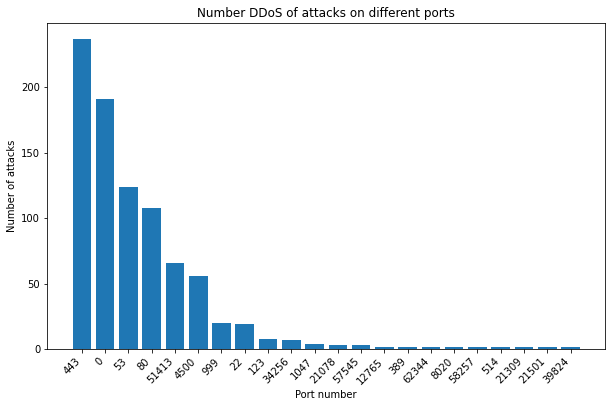

In [14]:
# create histogram for ports for ddos attacks with more than 1 attack
vc = attack_df[attack_df['Type'] == 'DDoS attack']['Port number'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(np.arange(0, len(vc[vc > 1]), 1), vc[vc > 1].values, label = vc[vc>1].index)
plt.title('Number DDoS of attacks on different ports')
plt.xlabel('Port number')
plt.ylabel('Number of attacks')
plt.xticks(np.arange(0, len(vc[vc > 1]), 1), vc[vc > 1].index, rotation=45, ha='right')

plt.savefig('../imgs/attack_df_port_dist.jpg', bbox_inches='tight')
plt.show()

There are a few special ports in the most frequent ones, lets see how many of them fall into the different types

In [15]:
attack_df[attack_df['Port number'] == 443]['Type'].value_counts().sort_index()

Type
DDoS attack            237
Normal traffic        5665
Suspicious traffic     119
Name: count, dtype: int64

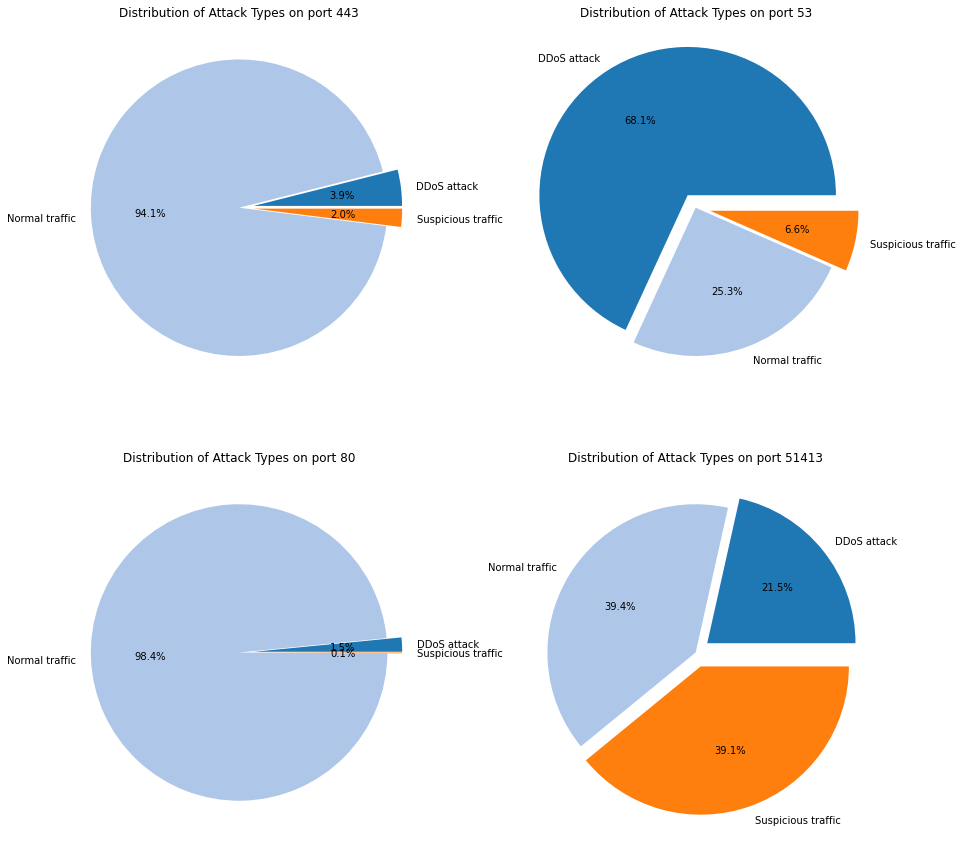

In [16]:
special_ports = [443, 53, 80, 51413]

fig, ax = plt.subplots(2,2, figsize=(15, 15))

for idx, port in enumerate(special_ports):
  vc = attack_df[attack_df['Port number'] == port]['Type'].value_counts().sort_index()
  explode = (0.1, 0, 0.1)

  ax[idx//2][idx%2].pie(vc.values, labels = vc.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors, explode = explode)
  ax[idx//2][idx%2].set_title(f"Distribution of Attack Types on port {port}")

plt.savefig('../imgs/attack_df_port_pie.jpg', bbox_inches='tight')

## Packet speed, Data speed, Avg packet len, Avg source IP count

In [17]:
# import functions
from visualise import calculate_zscores, create_violin_plots

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


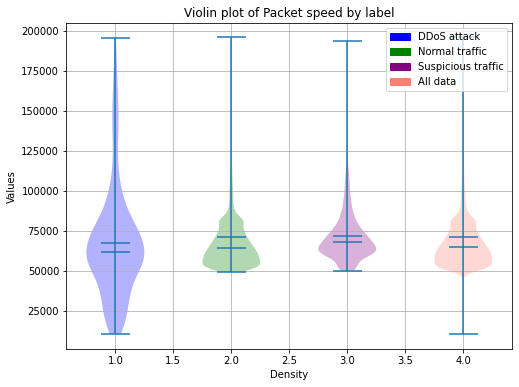

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


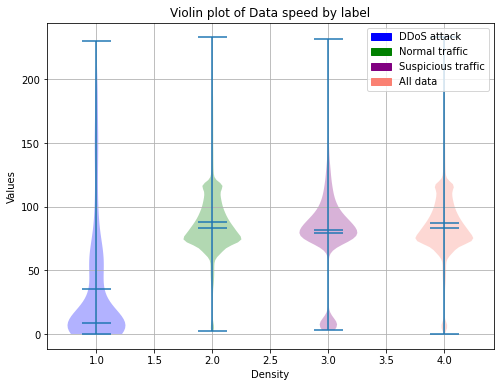

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


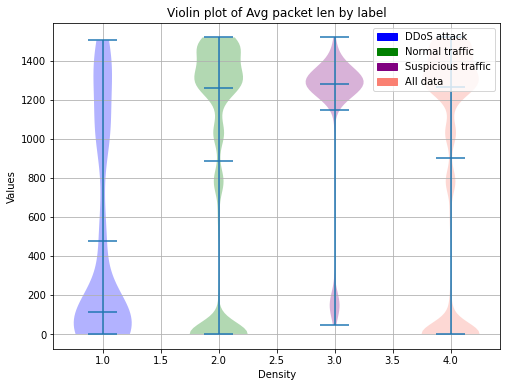

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


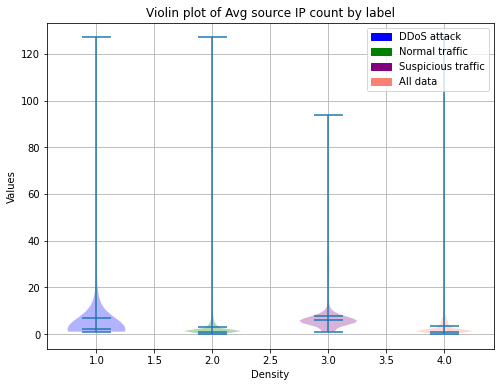

In [18]:
columns_to_plot = ['Packet speed', 'Data speed', 'Avg packet len', 'Avg source IP count']

for col in columns_to_plot:
  zscores = calculate_zscores(attack_df, col)
  create_violin_plots(attack_df, col, zscores, threshold = 3, labels= labels)

## Attack duration

In [19]:
# convert date columns
attack_df['Start time'] = pd.to_datetime(attack_df['Start time'].replace('0', np.nan), errors = 'coerce')
attack_df['End time'] = pd.to_datetime(attack_df['End time'].replace('0', np.nan), errors = 'coerce')
# drop NaN values
attack_df = attack_df.dropna(subset=['Start time', 'End time'])

In [20]:
# get attack duration

attack_df['Attack duration'] = attack_df['End time'] - attack_df['Start time']
attack_df['Attack duration'] = attack_df['Attack duration'].apply(lambda x: x.total_seconds())
attack_df['Attack duration'].describe()

count    134766.000000
mean         30.398409
std         213.921084
min           0.000000
25%           1.000000
50%           1.000000
75%           5.000000
max       41009.000000
Name: Attack duration, dtype: float64

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


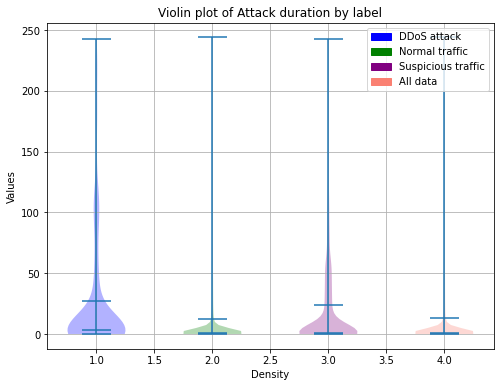

In [21]:
# plot
zscores = calculate_zscores(attack_df, 'Attack duration')
create_violin_plots(attack_df, 'Attack duration', zscores, threshold = 1, labels = labels)

# Vectors dataframe

In [22]:
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49


In [23]:
# add labels to the dataset
attack_df = pd.read_csv(attacks_path)
vector_df = pd.read_csv(vectors_path)
vector_df = pd.merge(vector_df, attack_df[['Attack ID', 'Type']], on='Attack ID', how='left')
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time,Type
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36,Normal traffic
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28,Normal traffic
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25,Normal traffic
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26,Normal traffic
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49,Normal traffic


Type
Normal traffic        448943
DDoS attack            79064
Suspicious traffic     58635
Name: count, dtype: int64


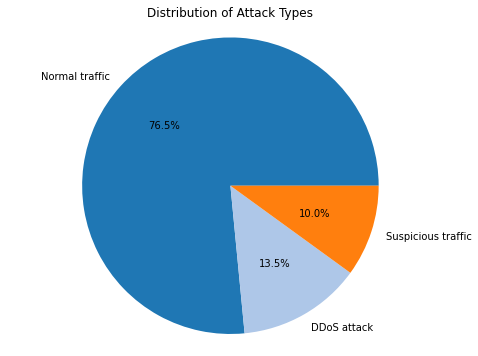

In [25]:
# see how many records are in different classes
value_counts = vector_df['Type'].value_counts()
labels = sorted(value_counts.index)
print(value_counts)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(value_counts.values, labels = value_counts.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors)
plt.axis('equal')
plt.title("Distribution of Attack Types")

plt.savefig('../imgs/vector_df_type_dist.jpg', bbox_inches='tight')

plt.show()

## Attack labels

In [26]:
# see how many records are with different attack codes of not normal traffic
value_counts = vector_df['Attack code'].value_counts()
print(value_counts)

Attack code
High volume traffic                                          520092
Suspicious traffic                                            38425
Generic UDP                                                    7239
Suspicious traffic, CLDAP                                      5000
Suspicious traffic, DNS                                        4810
CLDAP, High volume traffic                                     4308
NTP                                                            1175
Suspicious traffic, NTP                                        1020
DNS, High volume traffic                                       1015
CLDAP                                                           708
DNS                                                             490
SYN Attack                                                      411
DNS, CLDAP, High volume traffic                                 406
Suspicious traffic, SSDP                                        317
Suspicious traffic, DNS, CLDAP      

In [27]:
# there are multiple labels on some attacks
# get all the labels
attack_labels_mixed = list(value_counts.index)
attack_labels = []
for mixed_label in attack_labels_mixed:
  for label in mixed_label.split(','):
    attack_labels.append(label.strip())
# get the distinct labels
attack_labels = list(set(attack_labels))
attack_labels

['High volume traffic',
 'CLDAP',
 'ACK Attack',
 'Generic UDP',
 'RPC',
 'SSDP',
 'CoAP',
 'TCP Anomaly',
 'SNMP',
 'Sentinel',
 'CHARGEN',
 'SYN Attack',
 'IPv4 fragmentation',
 'Suspicious traffic',
 'RDP',
 'NTP',
 'DNS']

In [28]:
# count attacks for each label
label_count = {}
for label in attack_labels:
  count = vector_df['Attack code'].str.contains(label, case=False).sum()
  label_count[label] = count

# add all attack count
label_count['All attacks'] = len(vector_df)

# order the dict by frequency
label_count = dict(sorted(label_count.items(),key=lambda item: item[1], reverse = True))

for l, c in label_count.items():
  print(f"{l} : {c}")

All attacks : 586642
High volume traffic : 526205
Suspicious traffic : 50059
CLDAP : 10658
DNS : 7522
Generic UDP : 7240
NTP : 2481
SSDP : 445
SYN Attack : 412
IPv4 fragmentation : 347
SNMP : 234
CHARGEN : 60
RDP : 32
CoAP : 18
TCP Anomaly : 12
Sentinel : 5
ACK Attack : 4
RPC : 1


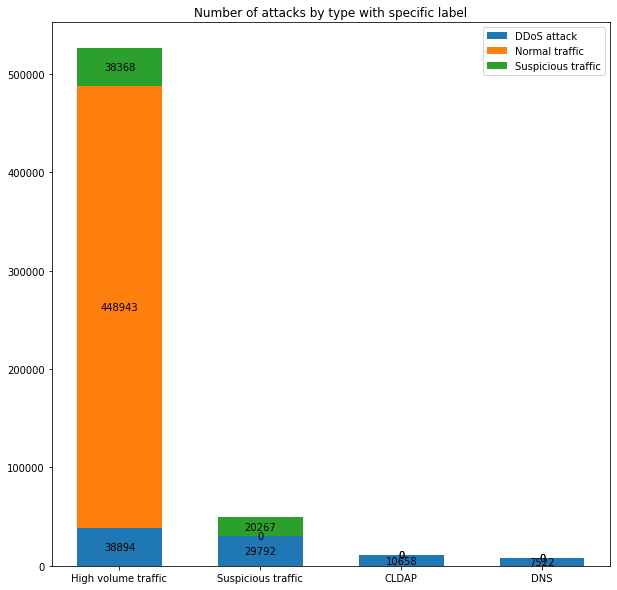

In [30]:
# lets check the class distribution for each label
# high volume and suspicious traffic, CLDAP, DNS are the most frequent lets check them seperately

# get the frequency of each class
attack_labels_to_plot = ('High volume traffic', 'Suspicious traffic', 'CLDAP', 'DNS')
num_attacks_by_type = {label: [] for label in labels}

for attack_label in attack_labels_to_plot:
  for k, _ in num_attacks_by_type.items():
    attack_label_df = vector_df[(vector_df['Attack code'].str.contains(attack_label, case=False))
                                & (vector_df['Type'] == k)]
    num_attacks_by_type[k].append(len(attack_label_df))

num_attacks_by_type

# plot it on a barplot
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
bottom = np.zeros(len(attack_labels_to_plot))

for label, count in num_attacks_by_type.items():
    p = ax.bar(attack_labels_to_plot, count, width, label=label, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of attacks by type with specific label')
ax.legend()

plt.savefig('../imgs/vector_df_attack_label_big.jpg', bbox_inches='tight')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


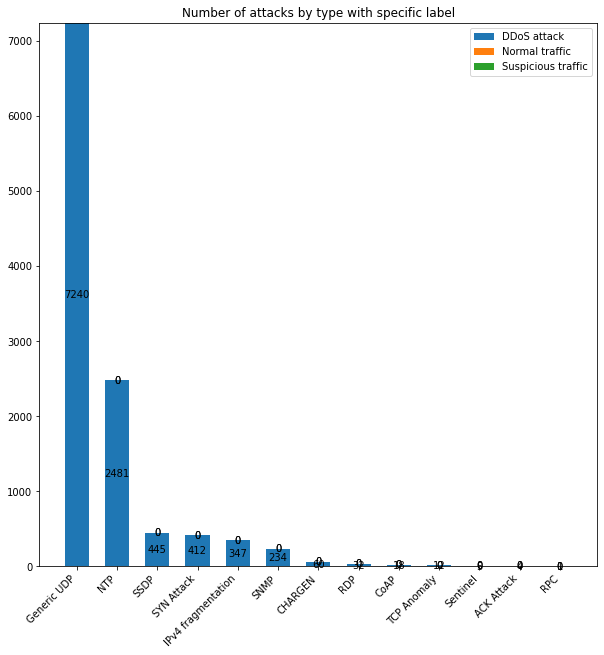

In [31]:
# check for the other labels
# lets check the class distribution for each label
# high volume and suspicious traffic are the most frequent lets check them seperately

# get the frequency of each class
attack_labels_to_plot = list(label_count.keys())[5:]
num_attacks_by_type = {label: [] for label in labels}

for attack_label in attack_labels_to_plot:
  for k, _ in num_attacks_by_type.items():
    attack_label_df = vector_df[(vector_df['Attack code'].str.contains(attack_label, case=False))
                                & (vector_df['Type'] == k)]
    num_attacks_by_type[k].append(len(attack_label_df))

num_attacks_by_type

# plot it on a barplot
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
bottom = np.zeros(len(attack_labels_to_plot))

for label, count in num_attacks_by_type.items():
    p = ax.bar(attack_labels_to_plot, count, width, label=label, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of attacks by type with specific label')
ax.legend()
plt.xticks(rotation=45, ha='right')

plt.savefig('../imgs/vector_df_attack_label_small.jpg', bbox_inches='tight')
plt.show()

## Numerical values analysis

In [32]:
# the number of unique values of each column
vector_df.nunique()

Attack ID           134769
Detect count         12534
Card                     1
Victim IP            18200
Port number          34137
Attack code             48
Significant flag         2
Packet speed          6173
Data speed            1523
Avg packet len        1447
Source IP count       2658
Time                528045
Type                     3
dtype: int64

## Port number

In [33]:
# Most frequent ports by label
for label in labels:
  print(f"Most frequent ports for {label}")
  print("port \t count")
  vc = vector_df[vector_df['Type'] == label]['Port number'].value_counts()
  print(vc[:5])
  print(f"There a {len(vc)} number of different ports for {label}")

Most frequent ports for DDoS attack
port 	 count
Port number
0        19553
51413    16997
443      15500
53       11784
80        4099
Name: count, dtype: int64
There a 636 number of different ports for DDoS attack
Most frequent ports for Normal traffic
port 	 count
Port number
0        105689
4500      53305
49261     45526
443       25756
60645     18330
Name: count, dtype: int64
There a 33152 number of different ports for Normal traffic
Most frequent ports for Suspicious traffic
port 	 count
Port number
0        13478
49261     7839
63396     4922
51413     3751
443       2074
Name: count, dtype: int64
There a 7450 number of different ports for Suspicious traffic


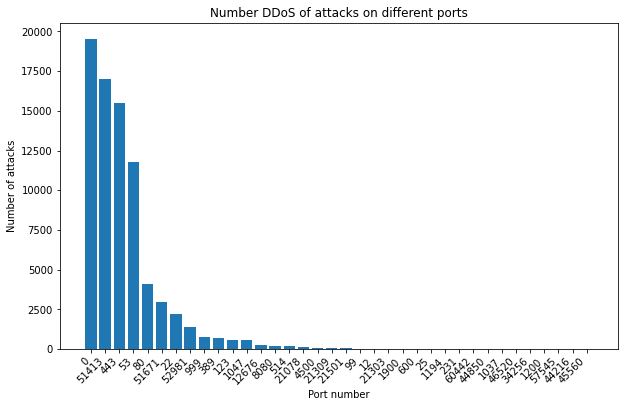

In [34]:
# create histogram for ports for ddos attacks with more than 1 attack
vc = vector_df[vector_df['Type'] == 'DDoS attack']['Port number'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(np.arange(0, len(vc[vc > 5]), 1), vc[vc > 5].values, label = vc[vc>5].index)
plt.title('Number DDoS of attacks on different ports')
plt.xlabel('Port number')
plt.ylabel('Number of attacks')
plt.xticks(np.arange(0, len(vc[vc > 5]), 1), vc[vc > 5].index, rotation=45, ha='right')

plt.savefig('../imgs/vector_df_port_dist.jpg', bbox_inches='tight')
plt.show()


In [35]:
vc = vector_df[vector_df['Port number'] == 51671]['Type'].value_counts().sort_index()
vc

Type
DDoS attack       2990
Normal traffic       4
Name: count, dtype: int64

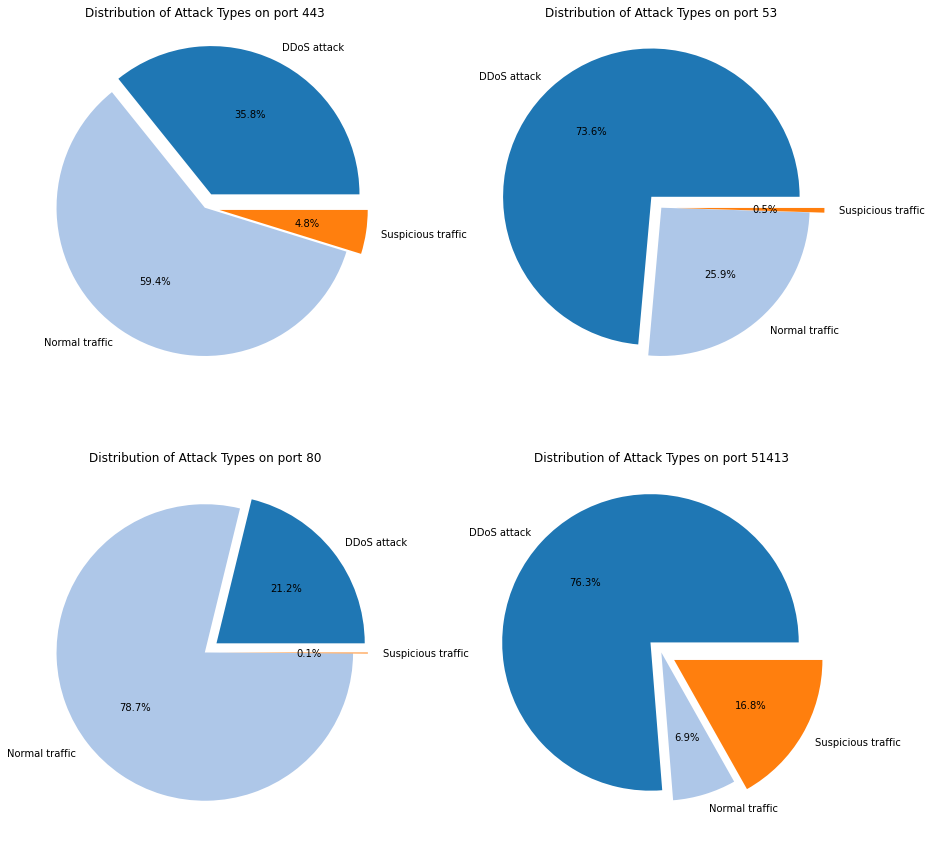

In [36]:
special_ports = [443, 53, 80, 51413]

fig, ax = plt.subplots(2,2, figsize=(15, 15))

for idx, port in enumerate(special_ports):
  vc = vector_df[vector_df['Port number'] == port]['Type'].value_counts().sort_index()
  explode = (0.1, 0, 0.1)

  ax[idx//2][idx%2].pie(vc.values, labels = vc.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors, explode = explode)
  ax[idx//2][idx%2].set_title(f"Distribution of Attack Types on port {port}")

plt.savefig('../imgs/vector_df_port_pie.jpg', bbox_inches='tight')

## Packet speed, Data speed, Avg packet len, Source IP count

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


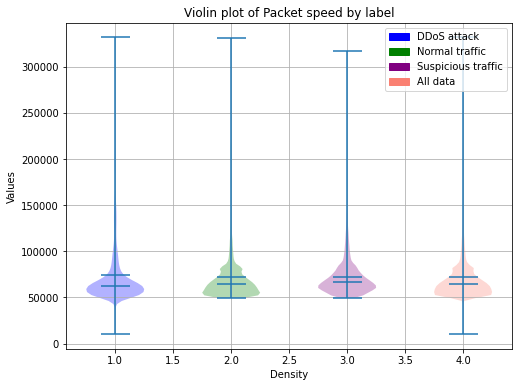

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


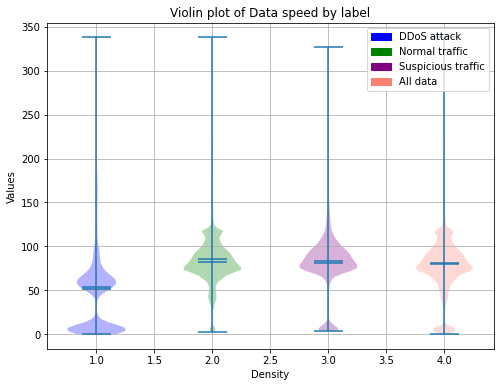

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


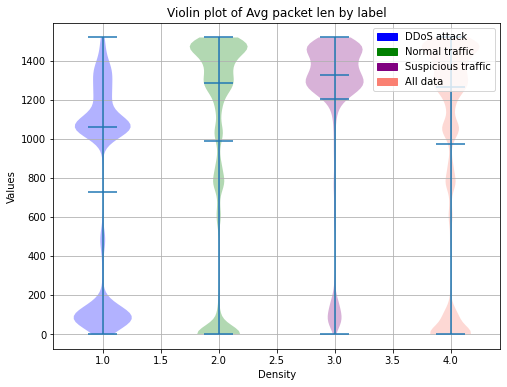

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


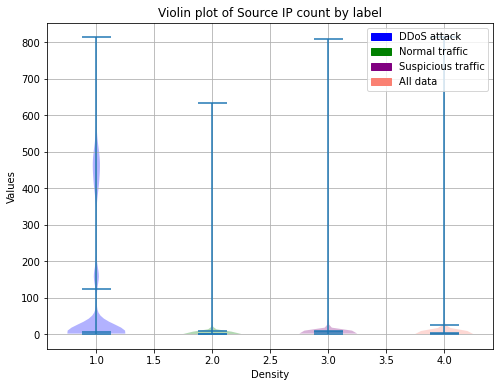

In [37]:
columns_to_plot = ['Packet speed', 'Data speed', 'Avg packet len', 'Source IP count']

for col in columns_to_plot:
  zscores = calculate_zscores(vector_df, col)
  create_violin_plots(vector_df, col, zscores, threshold = 3, labels = labels)

In [170]:
! zip -r images.zip imgs

  adding: imgs/ (stored 0%)
  adding: imgs/vector_df_attack_label_big.jpg (deflated 48%)
  adding: imgs/vector_df_violin_Avg packet len.jpg (deflated 31%)
  adding: imgs/vector_df_attack_label_small.jpg (deflated 37%)
  adding: imgs/attack_df_port_pie.jpg (deflated 29%)
  adding: imgs/attack_df_attack_label_small.jpg (deflated 47%)
  adding: imgs/attack_df_attack_label_big.jpg (deflated 52%)
  adding: imgs/attack_df_violin_Packet speed.jpg (deflated 33%)
  adding: imgs/attack_df_violin_Data speed.jpg (deflated 32%)
  adding: imgs/vector_df_port_pie.jpg (deflated 27%)
  adding: imgs/attack_df_violin_Attack duration.jpg (deflated 36%)
  adding: imgs/vector_df_violin_Data speed.jpg (deflated 34%)
  adding: imgs/vector_df_violin_Source IP count.jpg (deflated 41%)
  adding: imgs/vector_df_port_dist.jpg (deflated 33%)
  adding: imgs/vector_df_attack_label_medium.jpg (deflated 55%)
  adding: imgs/attack_df_port_dist.jpg (deflated 41%)
  adding: imgs/vector_df_type_dist.jpg (deflated 25%)
  ad